# Analysing seasonal trends

Spotify has been responsible for making many contributions to the music industry. It has become a *trendsetter* and as such understanding what makes a particular streaming music popular could hugely impact decision-making for music business. What makes spotify immensely useful to public is the ability to listen to any song we like at any time of the day depending on our mood. Unlike the old days when we had to be limited by the constraint of space and had to listen to only what was available now we can fine tune our music listening depending on the ups and downs of our modern life.

This project was influenced by the work of **Park et, al.**, where they reported that there exists diurnal and seasonal patterns in **affective preference** for music. After analysisng spotify streaming data for users across the world they came to the conclusion that users preferred different types of music through the day or seasons. In short they found that users preferered to listen to **low energy and acoustic songs during winter seasons**. Other researchers have reported similar findings (see references for more details), some articles detail neurological and psychological details to explain the existence of such patterns.

We were therefore interested to see **if the release of song by the music industry also follows such seasononal patterns**. By that we means do artists release a high energy song at specific times of the year to match users preference and general mood during the year or if the release of song is completely random with no regard to user's innate pattern. For the first part of this project we decide to only focus on energy and instrumentalness of the songs and leave further analysis for later stage.

In order to do this, we randomnly extracted 10000 songs each year for the last 20 years from spotify and also extracted audio features to help us in further analysis. We begin by first looking at general trends across the last 20 years and then seeing if there is a change in trends following recent advances in technology.


# Creating our Dataset

Spotify has provided with a very useful web API, along with a library specially built for working with python called **spotipy**. We will be using the spotipy library to make our API calls. We wrote some functions to help us get song data for each year as well for a list of years.

We will begin by first importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
from data_cleaning import go_spotify
import matplotlib.pyplot as plt
import seaborn as sns
import visualizations as viz
import hypothesis_tests as hypo
import statsmodels.api as sm
from statsmodels.formula.api import ols

np.random.seed(0)

In [2]:
# we begin by initialising our song extracting api.
spot = go_spotify(cid="", secret="")

# The function extracts all songs which are mentioned in the list of year.
years = [i for i in range (1999, 2019)]
#spot.get_many_years(years, to_csv=True)

Number of tracks where no audio features were available for year 1999: 0
number of songs: 9718
Number of tracks where no audio features were available for year 2000: 0
number of songs: 9714
Number of tracks where no audio features were available for year 2001: 0
number of songs: 9763
Number of tracks where no audio features were available for year 2002: 0
number of songs: 9655
Number of tracks where no audio features were available for year 2003: 0
number of songs: 9737
Number of tracks where no audio features were available for year 2004: 0
number of songs: 9632
Number of tracks where no audio features were available for year 2005: 0
number of songs: 9617
Number of tracks where no audio features were available for year 2006: 0
number of songs: 9564
Number of tracks where no audio features were available for year 2007: 0
number of songs: 9689
Number of tracks where no audio features were available for year 2008: 0
number of songs: 9623
Number of tracks where no audio features were avai

In [2]:
# we read the csv into a pandas dataframe to help us with analysis
df = pd.read_csv('Song Dataset.csv')
df.shape

(192323, 19)

We have collected a total of 192323 songs, there may be some songs that have the same track name and artists for different years and so the first thing we need to do is to ensure that there are no duplicates in our dataframe. We also need to make two new columns, one for **year** and the other for **month**. 

Those two columns will help us visualize the general trends to make sense of the data that we have obtained.


In [3]:
# creating two new column
df['year'] = df['release_date'].map(lambda x: x[:4])
df['month'] = df['release_date'].map(lambda x: x[5:7])
df = df[df.month != ''] # this is because some tracks only have a year mentioned.

# We need to make sure that the new columns are of type int so we can work with them more effectively
df['year'] = df.year.astype(int, inplace=True)
df['month'] = df.month.astype(int, inplace=True)

# Trends for audio features across the years

Now that we have a workable clean dataset, we can do our first exploratory analysis to see general trend of numeric features of songs across the last 20 years. We created a list of 12 audio features that are provided by spotify and see how the trends for them change our the last 20 years.

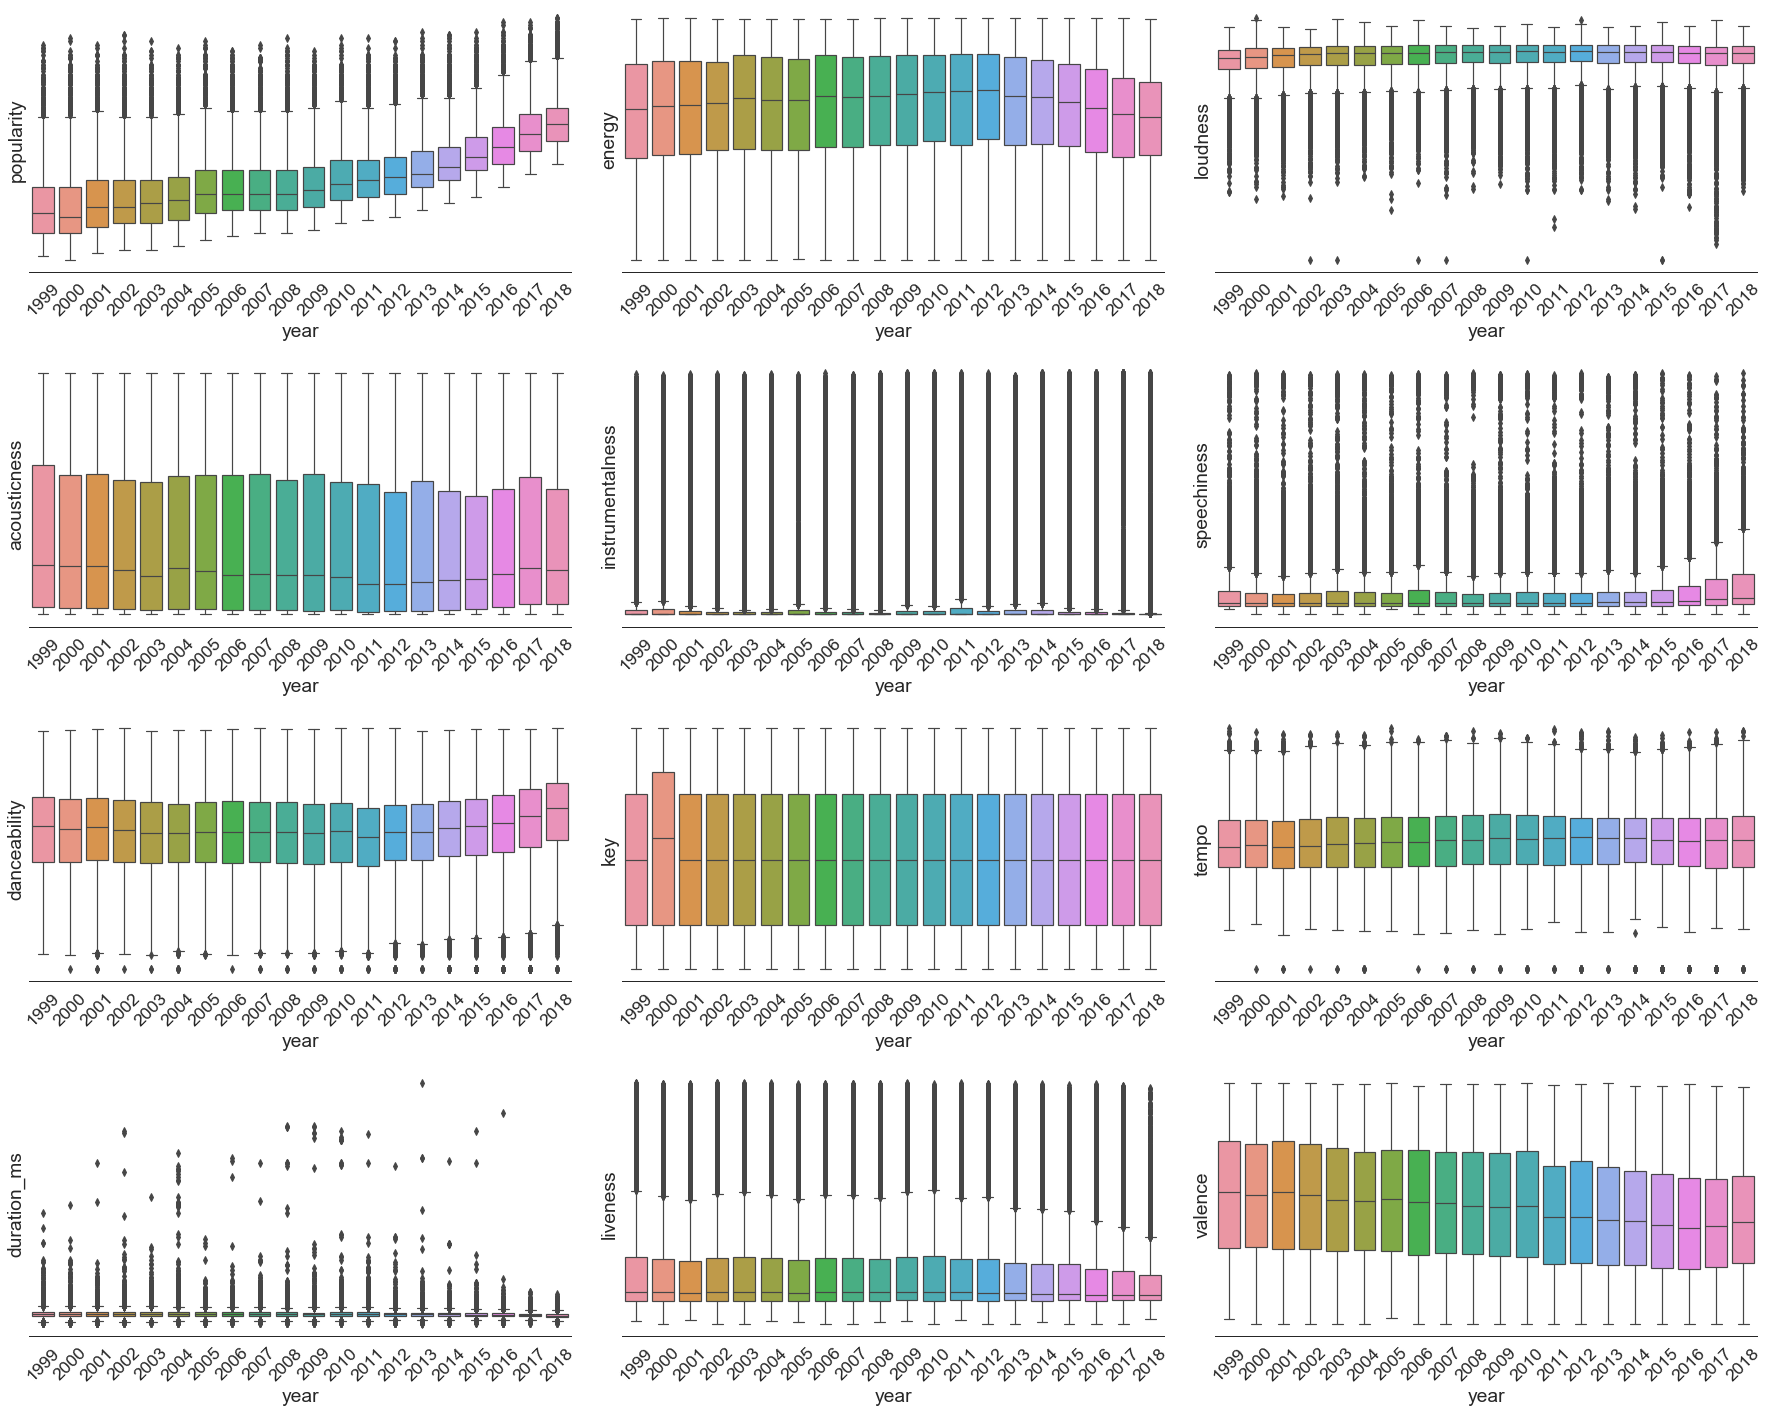

In [4]:
# import our functions from visualizations library

features = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy','instrumentalness', 
           'key', 'liveness', 'loudness','speechiness', 'tempo', 'valence']

series = df['year']
viz.box_subplots(4,3, df, series, features)


From first glance we can tell that songs are getting more popular through the year, but that is expected as it is a measure provided by spotify based on number of streaming and with time with possible that newer songs will have more streaming. What is more interesting is the effect on Loudness and energy of songs. Loudness and energy have slightly increased but energy of songs shows a decrease in recent years. Valence and acousticness of songs have shown a decrease, while danceability of song shows a noticeable increase. In general we can see that the variation of song based on these audio features have decreased and seem to converge at a smaller range. 

The feature that is of most interest to us for this first project is **energy** and **acousticness**. So we will first create a new dataframe consisting of only feature of interest. We will then create a new column called seasons which will then allow us to group our dataframe based on seasons. Also we will create another column called temperature which will split our data into two groups, warm months and cold months. So instead of having to look at the distributions for 4 different groups we can have a quick look at only two groups which makes it a lot more clearer.

In [5]:
test_features = ['year', 'month','energy','acousticness']
data = df.loc[:,test_features]

# we create a function that can calculate seasons
def seasons(m):
    if (m >= 3 and m <=5):
        return 'spring'
    elif (m >= 6 and m <=8):
        return 'summer'
    elif (m >= 9 and m <=11):
        return 'fall'
    else:
        return 'winter'


In [6]:
data['seasons'] = data['month'].map(lambda x: seasons(x))
data['temp'] = data['seasons'].map(lambda x: 'colder months' if (x == 'winter' or x =='fall') else 'warmer months')

Now that we have created a new column it will allow us to check the distribution of two of the features that we are most interested in. We can just get a general idea of whether the means or quartiles of the data are similar or different.

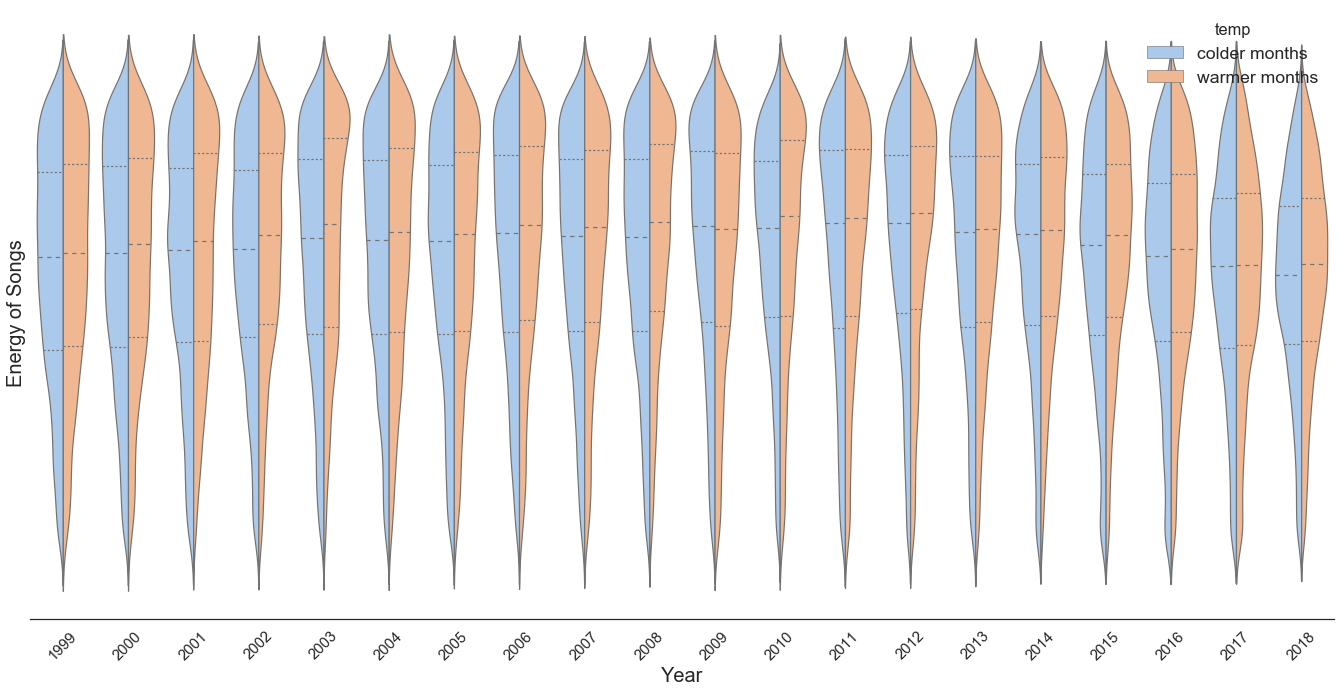

In [7]:
viz.sub_violinplots(data['year'], data['energy'], data['temp'], data, 'Energy of Songs', 'Year')

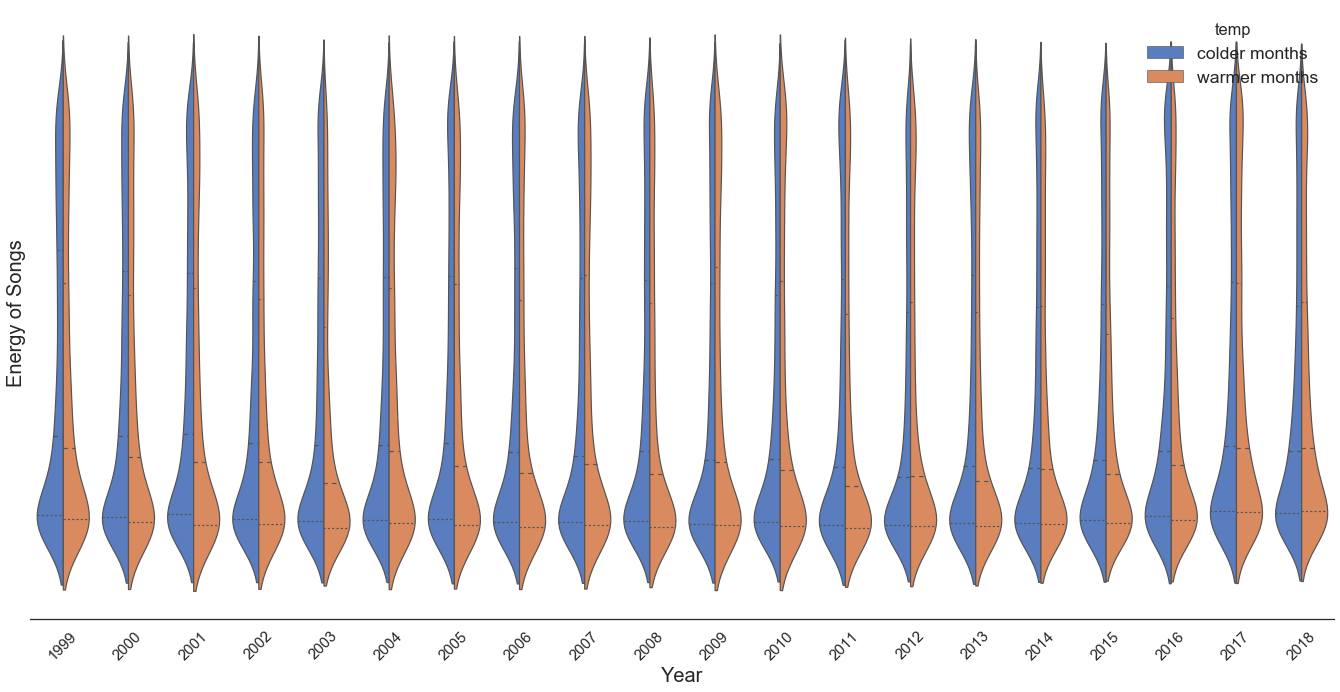

In [8]:
viz.sub_violinplots(data['year'], data['acousticness'], data['temp'], data, 'Acousticness of Songs', 'Year', "muted")

# Testing our hypothesis

We are planning to test the following hypothesis:

> **Are there seasonal trends in the release of high energy songs?**
>
> 1. Null: There is no change in energy of songs between summer and winter.
> 2. Alternative: Songs have more energy during the summer seasons.
    
> **Does the acousticness of songs released change depending on seasons?**
>
> 1. Null: The Season has no affect on the release of more accoustic songs
> 2. Alternative: Artist release more accoustic songs during winter.

We have 4 seasons and so we will be using a Anova test to check if there is indeed any seasonal variation for these features.

First we will check for seasonal variation in the whole of 20 years, by taking a random smaple and carrying out the Anova test.

In [9]:
# We take a small sample for our statistical testing
dftest = data[['seasons','energy','acousticness']].sample(1000)
dftest.sample(2)

,seasons,energy,acousticness
161590,fall,0.961,0.000446
170355,fall,0.033,0.995000


Now that we have a sample of our data, we can continue with our ANOVA testing, but before we do that we need a function that helps us get the effect size for our sample variation. Since we are using the statsmodel library to do our testing we will need to pass that function.

In [10]:
features_to_test = ['energy', 'acousticness']

hypo.anova(dftest, 'seasons', features_to_test)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
ANOVA of Energy against Seasons,0.209553,3.0,0.069851,1.113284,0.342672,0.003342,0.000340
ANOVA of Acousticness against Seasons,0.121308,3.0,0.040436,0.388336,0.761432,0.001168,-0.001838


In [12]:
dftest2 = data[['year','seasons','energy','acousticness']]
years = [i for i in range (1999, 2019)]

hypo.anova_loop(dftest2, 'seasons', ['energy'], years)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
ANOVA of Energy against Seasons for 1999,2.392634,3.0,0.797545,12.535550,3.577234e-08,0.004906,0.004514
ANOVA of Energy against Seasons for 2000,4.083413,3.0,1.361138,21.470530,7.635211e-14,0.008325,0.007936
ANOVA of Energy against Seasons for 2001,1.668172,3.0,0.556057,8.764334,8.452253e-06,0.003357,0.002973
ANOVA of Energy against Seasons for 2002,4.280073,3.0,1.426691,23.883452,2.222572e-15,0.009229,0.008841
ANOVA of Energy against Seasons for 2003,3.011914,3.0,1.003971,15.917002,2.575644e-10,0.005945,0.005571
ANOVA of Energy against Seasons for 2004,2.031033,3.0,0.677011,10.916396,3.756778e-07,0.004167,0.003785
ANOVA of Energy against Seasons for 2005,0.746840,3.0,0.248947,3.927908,8.191904e-03,0.001464,0.001091
ANOVA of Energy against Seasons for 2006,0.711913,3.0,0.237304,3.775478,1.011831e-02,0.001358,0.000998
ANOVA of Energy against Seasons for 2007,0.807444,3.0,0.269148,4.345586,4.577232e-03,0.001516,0.001167
ANOVA of Energy against Seasons for 2008,2.326455,3.0,0.775485,12.834031,2.304302e-08,0.004428,0.004083


In [13]:
hypo.anova_loop(dftest2, 'seasons', ['acousticness'], years)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
ANOVA of Acousticness against Seasons for 1999,3.008577,3.0,1.002859,9.235792,4.282648e-06,0.003619,0.003227
ANOVA of Acousticness against Seasons for 2000,6.233641,3.0,2.077880,20.200455,4.906662e-13,0.007836,0.007447
ANOVA of Acousticness against Seasons for 2001,2.496017,3.0,0.832006,7.938545,2.775398e-05,0.003041,0.002658
ANOVA of Acousticness against Seasons for 2002,4.239135,3.0,1.413045,13.893881,4.945698e-09,0.005390,0.005001
ANOVA of Acousticness against Seasons for 2003,8.221508,3.0,2.740503,27.399443,1.272017e-17,0.010190,0.009817
ANOVA of Acousticness against Seasons for 2004,1.392243,3.0,0.464081,4.518701,3.594292e-03,0.001729,0.001346
ANOVA of Acousticness against Seasons for 2005,1.881401,3.0,0.627134,5.899198,5.121898e-04,0.002197,0.001825
ANOVA of Acousticness against Seasons for 2006,3.236024,3.0,1.078675,9.927179,1.572691e-06,0.003564,0.003204
ANOVA of Acousticness against Seasons for 2007,1.102245,3.0,0.367415,3.403918,1.689166e-02,0.001188,0.000839
ANOVA of Acousticness against Seasons for 2008,1.860122,3.0,0.620041,5.936932,4.851503e-04,0.002053,0.001707
